# ADL Bi-Weekly Report 2
# EDA and CNN-based text classification evaluation on Stanford Sentiment Treebank dataset 
## Preetham Prashanth, Thava

References:
* Pytreebank - https://pypi.org/project/pytreebank/
* 1D Conv network - https://chriskhanhtran.github.io/posts/cnn-sentence-classification/
* Stanford Sentiment Treebank - https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
* Nbviewer - https://nbviewer.org/

## Note for visualizing my notebook:-
Please use nbviewer to view the visualizations for the .ipynb file

## Downloading dataset

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.max_colwidth = 300

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stanford-sentiment-treebank-v2-sst2/BERT-SST2-Dataset-Paper.pdf
/kaggle/input/stanford-sentiment-treebank-v2-sst2/Writing Code for NLP Research.pdf
/kaggle/input/stanford-sentiment-treebank-v2-sst2/SST2-Data/SST2-Data/stanfordSentimentTreebankRaw/stanfordSentimentTreebankRaw/README.txt
/kaggle/input/stanford-sentiment-treebank-v2-sst2/SST2-Data/SST2-Data/stanfordSentimentTreebankRaw/stanfordSentimentTreebankRaw/sentlex_exp12.txt
/kaggle/input/stanford-sentiment-treebank-v2-sst2/SST2-Data/SST2-Data/stanfordSentimentTreebankRaw/stanfordSentimentTreebankRaw/rawscores_exp12.txt
/kaggle/input/stanford-sentiment-treebank-v2-sst2/SST2-Data/SST2-Data/trainDevTestTrees_PTB/trees/test.txt
/kaggle/input/stanford-sentiment-treebank-v2-sst2/SST2-Data/SST2-Data/trainDevTestTrees_PTB/trees/train.txt
/kaggle/input/stanford-sentiment-treebank-v2-sst2/SST2-Data/SST2-Data/trainDevTestTrees_PTB/trees/dev.txt
/kaggle/input/stanford-sentiment-treebank-v2-sst2/SST2-Data/SST2-Data/stanfordSentim

## Pytreebank: A Python based library for downloading the Stanford Sentiment treebank dataset, and to visualize the tree form of each data sample
- Utilities for downloading, importing, and visualizing the Stanford Sentiment Treebank, a dataset capturing fine-grained sentiment over movie reviews.
- Allows for visualization using Jason Chuang's Javascript and CSS within an IPython notebook.

In [ ]:
!pip install pytreebank

  Preparing metadata (setup.py) ... done
  Created wheel for pytreebank: filename=pytreebank-0.2.7-py3-none-any.whl size=37071 sha256=472de46c91ff70d91916fbb9cbe39db46dcc7054c0e51b555e53422aaf63387a
  Stored in directory: /root/.cache/pip/wheels/5b/84/1b/8fbd390149c4c56517bf3cb62bb25d3cf6f5cf575e66710ced
Successfully built pytreebank


## Import required libraries

In [ ]:
import fasttext
import matplotlib.pyplot as plt
import pytreebank
import torch
import os,sys

## Reading and formatting dataset

In [ ]:
data = pytreebank.load_sst("/kaggle/input/stanford-sentiment-treebank-v2-sst2/SST2-Data/SST2-Data/trainDevTestTrees_PTB/trees/")

In [ ]:
# Showing a datasample from the dataset

# to_labeled_lines is a method which returns spans of different trees for a given sentence from the dataset, with the first element of the result 
# always being the full sentence, which is shown below.

for item in data['train']:
    print(item.to_labeled_lines()[1][0],item.to_labeled_lines()[0][1])
    break

2 The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .


In [ ]:
data['train'][0].to_labeled_lines()

[(3,
  "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal ."),
 (2, 'The Rock'),
 (2, 'The'),
 (2, 'Rock'),
 (4,
  "is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal ."),
 (3,
  "is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal"),
 (2, 'is'),
 (4,
  "destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal"),
 (2, 'destined'),
 (2,
  "to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal"),
 (2, "to be the 2

In [ ]:
out_path = os.path.join("/kaggle/working/sst_{}.txt")# new file format

#### Formatting data from {(label,sentence) => label  sentence} format

In [ ]:
for cat in ['train','test','dev']:
    with open(out_path.format(cat),"w") as file:
        for item in data[cat]:
            file.write("__label__{}\t{}\n".format(
                item.to_labeled_lines()[0][0],
                item.to_labeled_lines()[0][1]
            ))
    
    print("done with {}".format(file))

done with <_io.TextIOWrapper name='/kaggle/working/sst_train.txt' mode='w' encoding='UTF-8'>
done with <_io.TextIOWrapper name='/kaggle/working/sst_test.txt' mode='w' encoding='UTF-8'>
done with <_io.TextIOWrapper name='/kaggle/working/sst_dev.txt' mode='w' encoding='UTF-8'>


In [ ]:
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/sst_train.txt
/kaggle/working/sst_test.txt
/kaggle/working/sst_dev.txt
/kaggle/working/__notebook_source__.ipynb


In [ ]:
# Number of sentences in the train set
len(data['train'])

8544

In [ ]:
# Reading the formatted files from pandas
train = pd.read_csv("/kaggle/working/sst_train.txt",sep="\t",header=None,names=['label','text'])
train['label'] = train['label'].str.replace("__label__","")
train['label'] = train['label'].astype(int).astype("category")

In [ ]:
# Adding a new column to store lengths of all sentences
train['len'] = train['text'].str.len()

In [ ]:
train.head()

,label,text,len
0,3,"The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .",181
1,4,The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .,226
2,3,"Singer/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply intrusive to the story -- but the whole package certainly captures the intended , er , spirit of the piece .",208
3,2,You 'd think by now America would have had enough of plucky British eccentrics with hearts of gold .,100
4,3,Yet the act is still charming here .,36


In [ ]:
# This function returns statistics of numerical columns in the DataFrame, here, it is the 'len' column
train.describe()

,len
count,8544.000000
mean,102.310393
std,51.430023
min,4.000000
25%,62.000000
50%,98.000000
75%,137.000000
max,267.000000


In [ ]:
test = pd.read_csv("/kaggle/working/sst_test.txt",sep="\t",header=None,names=['label','text'])
test['label'] = test['label'].str.replace("__label__","")
test['label'] = test['label'].astype(int).astype("category")

In [ ]:
test.head()

,label,text
0,2,Effective but too-tepid biopic
1,3,"If you sometimes like to go to the movies to have fun , Wasabi is a good place to start ."
2,4,"Emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one ."
3,2,The film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .
4,4,Offers that rare combination of entertainment and education .


In [ ]:
train.label.value_counts().sort_index()

0    1092
1    2218
2    1624
3    2322
4    1288
Name: label, dtype: int64

In [ ]:
label_values = {
    0: 'Very negative',
    1: 'Negative',
    2: 'Neutral',
    3: 'Positive',
    4: 'Very positive'
}

In [ ]:
# Adding a column to insert label text for numerical sentence labels
train['label_text'] = train['label'].apply(lambda x : label_values[x])

In [ ]:
# Shows a part of the DataFrame with the new columns populated.
train.head()

,label,text,len,label_text
0,3,"The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .",181,Positive
1,4,The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .,226,Very positive
2,3,"Singer/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply intrusive to the story -- but the whole package certainly captures the intended , er , spirit of the piece .",208,Positive
3,2,You 'd think by now America would have had enough of plucky British eccentrics with hearts of gold .,100,Neutral
4,3,Yet the act is still charming here .,36,Positive


[Text(0, 0, 'Very negative'),
 Text(0, 1, 'Negative'),
 Text(0, 2, 'Neutral'),
 Text(0, 3, 'Positive'),
 Text(0, 4, 'Very positive')]

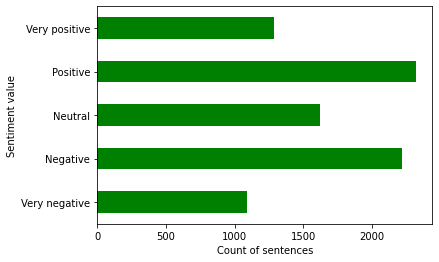

In [ ]:
ax = train.label.value_counts().sort_index().plot(kind='barh', figsize = (6, 4), color = 'g')
ax.set_xlabel('Count of sentences')
ax.set_ylabel('Sentiment value')
ax.set_yticklabels(label_values.values())

There seems to be a slight imbalance in classes of sentences of the training dataset. 
Positive and Negative sentences are more in number compared to the other 'very positive', 'very negative' and 'neutral' labeled sentences.

## Visualizations of treebank dataset

To display more than one Labeled Tree visualizations using pytreebank and JS, we have to follow these steps:
1. Clear outputs of all visualization instances
2. Run the last instance of the visualization, then run a corresponding display command
3. Then, run the last non-running instance, and continue as before

In [ ]:
pytreebank.LabeledTree.inject_visualization_javascript()

The above tree bank visualization is from the train dataset - Sample 1
<br>
Sample 1 is categorised as 'positive' sentiment text, and this might be because most of the words present in the sentence are categorised into 'positive' sentiment trees. There are a few neutral branches as well, and there is only one 'negative' tree branch, thus the sentence finally leans toward a 'positive' sentiment.

In [ ]:
data['train'][37].display()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pytreebank.LabeledTree.inject_visualization_javascript()

The above tree bank visualization is from the train dataset - Sample 2
<br>
Sample 2 is categorised as a 'very positive' sentiment text, and this might be because most of the words present in the sentence are categorised into 'very positive' sentiment trees. There are a few neutral branches and a few positive branches, and there is only one 'negative' tree branch, thus the sentence finally leans toward a majority sentiment in all branches - 'very positive' text.

In [ ]:
data['test'][30].display()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pytreebank.LabeledTree.inject_visualization_javascript()

The above tree bank visualization is from the train dataset - Sample 3
<br>
Sample 3 is categorised as a 'positive' sentiment text, and this might be because most of the words present in the sentence are categorised into 'positive' sentiment trees. There are a lot more neutral branches than the positive branches, but still the sentence finally leans toward a 'positive' text. Though, from Sample 2 we think the majority sentiment in all branches is the final sentiment of text, possibly these sentiment branches are weighted with different values, thus neutral might have a very low weight, leading it to be supressed most of the times. So, that we get a non-neutral sentiment for a given text.

In [ ]:
data['train'][100].display()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_df, test_df = train, test


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
train_df.head(8)

,label,text,len,label_text
0,3,"The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .",181,Positive
1,4,The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .,226,Very positive
2,3,"Singer/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply intrusive to the story -- but the whole package certainly captures the intended , er , spirit of the piece .",208,Positive
3,2,You 'd think by now America would have had enough of plucky British eccentrics with hearts of gold .,100,Neutral
4,3,Yet the act is still charming here .,36,Positive
5,4,"Whether or not you 're enlightened by any of Derrida 's lectures on `` the other '' and `` the self , '' Derrida is an undeniably fascinating and playful fellow .",162,Very positive
6,4,Just the labour involved in creating the layered richness of the imagery in this chiaroscuro of madness and light is astonishing .,130,Very positive
7,3,Part of the charm of Satin Rouge is that it avoids the obvious with humour and lightness .,90,Positive


### Downloading FastText vectors
- This vector representation is based off the paper - 'Bag of Tricks for Efficient Text Classification'
- It is very lightweight, fast and also linear in computation size

In [ ]:
%%time
URL = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
FILE = "fastText"

if os.path.isdir(FILE):
    print("fastText exists.")
else:
    !wget -P $FILE $URL
    !unzip $FILE/crawl-300d-2M.vec.zip -d $FILE

--2023-02-15 08:42:18--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘fastText/crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  39.3MB/s    in 39s     

2023-02-15 08:42:58 (37.1 MB/s) - ‘fastText/crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]

Archive:  fastText/crawl-300d-2M.vec.zip
  inflating: fastText/crawl-300d-2M.vec  
CPU times: user 1.64 s, sys: 276 ms, total: 1.91 s
Wall time: 1min 24s


### To activate GPU if available

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda:0")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: Tesla T4


### Data cleaning
- Remove stop words
- Lowercase all words in given sentence, after it is stripped of trailing whitespaces
- Remove all symbols and characters which are not part of the alphabet
- Lemmatized version of each word is appended into the final string

In [ ]:
import re
import nltk
import nltk.corpus
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer


def clean_data(text):
    stop = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    
    text = text.strip().lower()
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    stext = []
    for word in text.split():
        if word not in stop:
            stext.append(lemmatizer.lemmatize(word))
    return ' '.join(stext)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [ ]:
train_df['text_cleaned'] = train_df['text'].apply(lambda x: clean_data(x))
test_df['text_cleaned'] = test_df['text'].apply(lambda x: clean_data(x))

In [ ]:
train_sents = train_df['text_cleaned'].values
train_labels = train_df['label'].values

test_sents = test_df['text_cleaned'].values
test_labels = test_df['label'].values

In [ ]:
train_df

,label,text,len,label_text,text_cleaned
0,3,"The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .",181,Positive,rock destined 21st century new conan going make splash even greater arnold schwarzenegger jeanclaud van damme steven segal
1,4,The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .,226,Very positive,gorgeously elaborate continuation lord ring trilogy huge column word adequately describe cowriterdirector peter jackson expanded vision jrr tolkien middleearth
2,3,"Singer/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply intrusive to the story -- but the whole package certainly captures the intended , er , spirit of the piece .",208,Positive,singercomposer bryan adam contributes slew song potential hit simply intrusive story whole package certainly capture intended er spirit piece
3,2,You 'd think by now America would have had enough of plucky British eccentrics with hearts of gold .,100,Neutral,think america would enough plucky british eccentric heart gold
4,3,Yet the act is still charming here .,36,Positive,yet act still charming
...,...,...,...,...,...
8539,0,A real snooze .,15,Very negative,real snooze
8540,1,No surprises .,14,Negative,surprise
8541,3,"We 've seen the hippie-turned-yuppie plot before , but there 's an enthusiastic charm in Fire that makes the formula fresh again .",130,Positive,seen hippieturnedyuppie plot enthusiastic charm fire make formula fresh
8542,0,"Her fans walked out muttering words like `` horrible '' and `` terrible , '' but had so much fun dissing the film that they did n't mind the ticket cost .",154,Very negative,fan walked muttering word like horrible terrible much fun dissing film nt mind ticket cost


### Tokenization and padding of sentences
- Essentially, senetnces are broken into words (tokens), then they are all padded to equal length in the whole dataset with encoded indices for all tokens

In [ ]:
from nltk.tokenize import word_tokenize
from collections import defaultdict

def tokenize(texts):
    """Tokenize texts, build vocabulary and find maximum sentence length.
    
    Args:
        texts (List[str]): List of text data
    
    Returns:
        tokenized_texts (List[List[str]]): List of list of tokens
        word2idx (Dict): Vocabulary built from the corpus
        max_len (int): Maximum sentence length
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Add <pad> and <unk> tokens to the vocabulary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Building our vocab from the corpus starting from index 2
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)

        # Add `tokenized_sent` to `tokenized_texts`
        tokenized_texts.append(tokenized_sent)

        # Add new token to `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # Update `max_len` - this is used to pad all sentences to equal length
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

def encode(tokenized_texts, word2idx, max_len):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns:
        input_ids (np.array): Array of token indexes in the vocabulary with
            shape (N, max_len). It will be the input of our CNN model.
    """

    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token, 0) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

### Pretrained vectors are loaded and returned as an embedding matrix

In [ ]:
from tqdm import tqdm_notebook

def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initialize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d)) # random for all words not in pretrained vector representations
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [ ]:
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
train_tokenized_texts, word2idx, max_len = tokenize(train_sents)
train_input_ids = encode(train_tokenized_texts, word2idx, max_len)

# Load pretrained vectors
embeddings = load_pretrained_vectors(word2idx, "fastText/crawl-300d-2M.vec")
train_embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

There are 13413 / 14969 pretrained vectors found.


In the below output, we can see all kinds of tokens generated from the corpus
<br>Words like cowriterdirector, peter, tolkien - are all made-up words with no existence in other literature which was used to train the FastText vector representation models, so these words need to be given random tensor embedding values, thus we initialise the word vocab to random initially.

In [ ]:
list(word2idx.keys())[30:50]

['describe',
 'cowriterdirector',
 'peter',
 'jackson',
 'expanded',
 'vision',
 'jrr',
 'tolkien',
 'middleearth',
 'singercomposer',
 'bryan',
 'adam',
 'contributes',
 'slew',
 'song',
 'potential',
 'hit',
 'simply',
 'intrusive',
 'story']

In [ ]:
test_tokenized_texts, _, _ = tokenize(test_sents)
test_input_ids = encode(test_tokenized_texts, word2idx, max_len)

In [ ]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)

def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader in batches through sampling as specified - random or sequential order.
    
    PyTorch uses this DataLoader framework to input data into the Torch models in batches as Tensors.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

In [ ]:
# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = \
data_loader(train_input_ids, test_input_ids, train_labels, test_labels, batch_size=50)

## 1D CNN model for text-classification

In [ ]:
# Filter configuration:
filter_sizes = [5, 10, 15]
num_filters = [200, 200, 200]

We are using a 1D CNN model for text classification as in below image. This architecture is taken from [A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1510.03820) (Zhang, 2015).
<br>
The sentence text is split into tokens, these are transformed into tensors. Then, these tensors are sent as input to the CNN setup. The convolutions occurs in this model only in one direction, since the filters are already covering up the other dimensions.
Lets suppose for a batch input of shape (batch_size, max_length of sent, embedding dimension), with 1D convolutional operations, the filters only move in the axis of embedding dimension, while the other two dimension axes make the filter length and width.
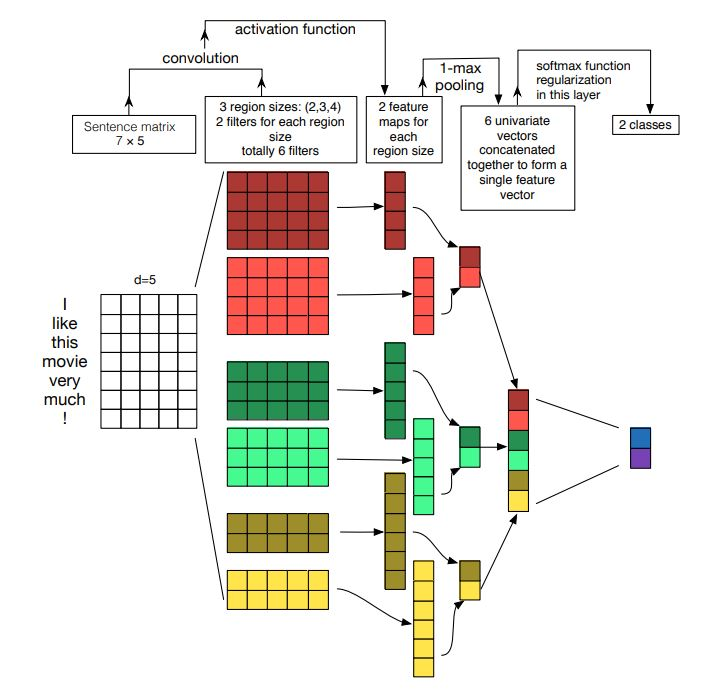

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretrained
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return self.sigmoid(logits)

In [ ]:
import torch.optim as optim

def initialize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=num_classes,
                        dropout=dropout)
    print(cnn_model)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

In [ ]:
import random
import time
import matplotlib.pyplot as plt

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)

def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0
    val_loss_l, train_loss_l = [], [] 

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        train_loss_l.append(avg_train_loss)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            val_loss_l.append(val_loss)
            

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
          
    ax = plt.axes()
    plt.xlabel("Epoch number")
    plt.ylabel("Loss")
    plt.title("Training and Validation loss curve")

    plt.plot([i for i in range(epochs)], val_loss_l, 'b', label = 'Val loss curve')
    plt.plot([i for i in range(epochs)], train_loss_l, 'g', label = 'Train loss curve')
    plt.legend()

    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

CNN_NLP(
  (embedding): Embedding(14969, 300, padding_idx=0, max_norm=5.0)
  (conv1d_list): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=5, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.574705   |  1.576716  |   23.91   |   10.67  
   2    |   1.563106   |  1.575063  |   25.24   |   2.08   
   3    |   1.556290   |  1.571908  |   24.31   |   2.07   
   4    |   1.546294   |  1.566324  |   29.29   |   1.99   
   5    |   1.530652   |  1.558700  |   29.56   |   1.97   
   6    |   1.510247   |  1.548232  |   33.20   |   1.99   
   7    |   1.483206   |  1.541061  |   33.24   |   1.99   
   8    |   1.453545   |  1.535776

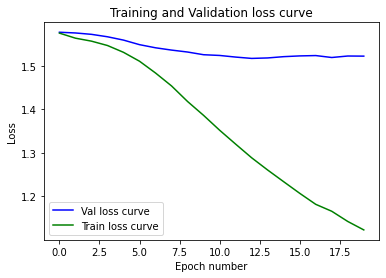

In [ ]:
# CNN-rand: Word vectors are randomly initialized.
set_seed(42)
cnn_rand, optimizer = initialize_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      filter_sizes=[3, 4, 5],
                                      num_filters=[100, 100, 100],
                                      num_classes=5,
                                      learning_rate=0.25,
                                      dropout=0.5)

cnn_rand.to(device)
train(cnn_rand, optimizer, train_dataloader, val_dataloader, epochs=20)
del cnn_rand

CNN_NLP(
  (embedding): Embedding(14969, 300)
  (conv1d_list): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=5, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.568528   |  1.567660  |   35.33   |   1.25   
   2    |   1.542767   |  1.530338  |   39.38   |   1.39   
   3    |   1.490245   |  1.467183  |   39.51   |   1.50   
   4    |   1.439833   |  1.440588  |   39.29   |   1.51   
   5    |   1.412155   |  1.424769  |   39.60   |   1.64   
   6    |   1.394518   |  1.415406  |   39.73   |   1.60   
   7    |   1.380982   |  1.406564  |   40.93   |   1.57   
   8    |   1.366705   |  1.403919  |   41.38   |   1.55   
   

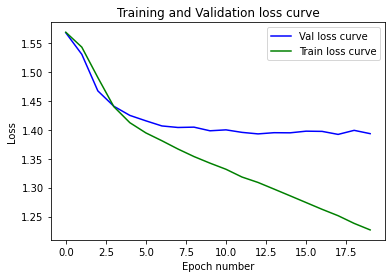

In [ ]:
# CNN-static: fastText pretrained word vectors are used and freezed during training.
set_seed(42)
cnn_static, optimizer = initialize_model(pretrained_embedding=train_embeddings,
                                        freeze_embedding=True,
                                        filter_sizes=[3, 4, 5],
                                        num_filters=[100, 100, 100],
                                        num_classes=5,
                                        learning_rate=0.25,
                                        dropout=0.5)
cnn_static.to(device)
train(cnn_static, optimizer, train_dataloader, val_dataloader, epochs=20)
del cnn_static

CNN_NLP(
  (embedding): Embedding(14969, 300)
  (conv1d_list): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=5, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.570589   |  1.569969  |   28.67   |   2.68   
   2    |   1.545951   |  1.534274  |   36.71   |   2.51   
   3    |   1.496058   |  1.472063  |   39.78   |   2.56   
   4    |   1.443065   |  1.438411  |   39.96   |   2.59   
   5    |   1.412523   |  1.424867  |   39.73   |   2.92   
   6    |   1.393482   |  1.417579  |   39.82   |   3.06   
   7    |   1.377422   |  1.405650  |   40.71   |   2.64   
   8    |   1.362874   |  1.400151  |   41.51   |   2.58   
   

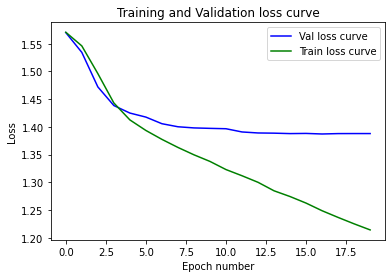

In [ ]:
# CNN-non-static: fastText pretrained word vectors are fine-tuned during training.
set_seed(42)
cnn_non_static, optimizer = initialize_model(pretrained_embedding=train_embeddings,
                                            freeze_embedding=False,
                                            filter_sizes=[3, 4, 5],
                                            num_filters=[100, 100, 100],
                                            num_classes=5,
                                            learning_rate=0.25,
                                            dropout=0.5)
cnn_non_static.to(device)
train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=20)
del cnn_non_static

We can see that in all 3 models above, overfitting is happening since train loss keeps decreasing, while val loss isnt decreasing after a certain epoch. This is because, the model has become too complex for capturing the data, we should decrease the number of filters or the filter sizes, which is done below. Experimenting with various hyperparameters(num_filters, filter_sizes, learning_rate and dropout) led to the above set of values which gives the best possible val accuracy using a 1D conv layer. 
<br>
We can also notice that, while training, val accuracy easily goes until 40%, but after that it doesn't get better much. This is because, val loss decreases at a vey slow pace, while train loss drastically reduces leading to an overfitting condition as described above.

CNN_NLP(
  (embedding): Embedding(14969, 300)
  (conv1d_list): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=5, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.567203   |  1.561606  |   30.98   |   2.80   
   2    |   1.519954   |  1.486479  |   39.33   |   2.53   
   3    |   1.447114   |  1.433103  |   39.96   |   3.10   
   4    |   1.406749   |  1.417119  |   40.09   |   2.54   
   5    |   1.383326   |  1.412065  |   40.18   |   2.53   
   6    |   1.365504   |  1.401302  |   41.16   |   2.53   
   7    |   1.346169   |  1.395115  |   41.24   |   2.68   
   8    |   1.326712   |  1.392522  |   41.16   |   2.53   
   

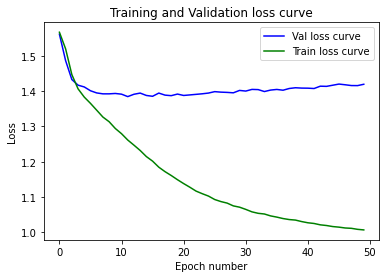

In [ ]:
# Even with multiple experimentations, the accuracy didnt budge. All the time, it leads to an overfitting scenario.

set_seed(42)
cnn_non_static_b, optimizer = initialize_model(pretrained_embedding=train_embeddings,
                                            freeze_embedding=False,
                                            filter_sizes=[3, 4, 5],
                                            num_filters=[100, 100, 100],
                                            num_classes=5,
                                            learning_rate=0.35,
                                            dropout=0.5)
cnn_non_static_b.to(device)
train(cnn_non_static_b, optimizer, train_dataloader, val_dataloader, epochs=50)
del cnn_non_static_b

In [ ]:
# Number of train sentences
len(train_input_ids)

8544

In [ ]:
# Number of test sentences for validation
len(test_input_ids)

2210

In [ ]:
def predict(text, model=cnn_non_static.to("cpu"), max_len=62):
    """Predict probability that a review is positive."""

    # Tokenize, pad and encode text
    tokens = word_tokenize(text.lower())
    padded_tokens = tokens + ['<pad>'] * (max_len - len(tokens))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]

    # Convert to PyTorch tensors
    input_id = torch.tensor(input_id).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = F.softmax(logits, dim=1).squeeze(dim=0)
    pred_label, pred_prob = torch.argmax(probs), torch.max(probs)

    print(f"The sentiment review for the sentence \n<<{text}>>\n is {pred_prob * 100:.2f}% belonging to class \'{label_values[int(pred_label)+1]}\'.")

In the below predictions with unseen texts, we see the model performs fairly well in choosing the right class of sentiment for each text but the confidence with which it picks the label could be improved further with either a different model or a different representation maybe.

In [ ]:
predict("All of my friends slept while watching this movie. But I really enjoyed it.")
predict("I have waited so long for this movie. I am now so satisfied and happy.")
predict("This movie is long and boring.")
predict("I don't like the ending.")

The sentiment review for the sentence 
<<All of my friends slept while watching this movie. But I really enjoyed it.>>
 is 32.17% belonging to class 'Very positive'.
The sentiment review for the sentence 
<<I have waited so long for this movie. I am now so satisfied and happy.>>
 is 31.74% belonging to class 'Very positive'.
The sentiment review for the sentence 
<<This movie is long and boring.>>
 is 32.92% belonging to class 'Neutral'.
The sentiment review for the sentence 
<<I don't like the ending.>>
 is 26.85% belonging to class 'Very positive'.


In [ ]:
predict(train_df.text[90])

The sentiment review for the sentence 
<<Allen shows he can outgag any of those young whippersnappers making moving pictures today .>>
 is 30.87% belonging to class 'Very positive'.


In [ ]:
train_labels[90]

3

# Conclusion
In this report, I carried out EDA on Stanford Sentiment Treebank dataset and tried to classify the 5 sentiment labels correctly for all senetnces in dataset, but wasnt able to get a very good score. However, with this experiment, we have seen the effectiveness of 1D CNN for text sentiment classification. 